# TOC

__Chapter 07 - Feature learning__

1. [Import](#Import)
1. [Parametric assumptions of data](#Parametric-assumptions-of-data)
1. [Restricted Boltzmann Machines](#Restricted-Boltzmann-Machines)
    1. [BernoulliRBM](#BernoulliRBM)
    1. [Experiment - Extracting PCA components from MNIST](#Extracting-PCA-components-from-MNIST)
1. [](#)
1. [](#)
1. [](#)


<a id = 'Import'></a>

# Import

In [19]:
# Standard libary and settings
import os
import sys
import importlib
import itertools
import warnings; warnings.simplefilter('ignore')
modulePath = os.path.abspath(os.path.join('../../CustomModules'))
sys.path.append(modulePath) if modulePath not in sys.path else None
from IPython.core.display import display, HTML; display(HTML("<style>.container { width:95% !important; }</style>"))


# Data extensions and settings
import numpy as np
np.set_printoptions(threshold = np.inf, suppress = True)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.6f}'.format


# Modeling extensions
import sklearn.neural_network as neural_network
import sklearn.preprocessing as preprocessing
import sklearn.pipeline as pipeline
import sklearn.neighbors as neighbors
import sklearn.model_selection as model_selection



# Visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt


# Custom extensions and settings
from quickplot import qp, qpUtil, qpStyle
import mlmachine as mlm
sns.set(rc = qpStyle.rcGrey)


# Magic functions
%matplotlib inline


<a id = 'Parametric-assumptions-of-data'></a>

# Parametric assumptions of data

Feature learning algorithms remove the parametric assumption of data that PCA and LDA make. Rather than making assumptions about the shape of the data, these feature learning techniques rely on stochastic learning - that is, an iterative process is performed on the data rather than a well-defined linear transformation.

That being said, non-parametric techniques that will be discussed here still make assumptions about the data, just not the shape. Here are some examples of non-parametric feature extraction techniques:

- Restricted Boltzmann Machine (RBM)
- Word embeddings

<a id = 'Restricted-Boltzmann-Machines'></a>

# Restricted Boltzmann Machines

RBMs are a family of unsupervised feature learning algorithms that use probabilistic models to learn new features. Just as with PCA and LDA, RBMs extract new features from raw data. These new features tend to work best when followed by linear models.

Conceptually, RBMs can be thought of as shallow neural networks, having only two layers. It is an unsupervised method, so there is only a visible layer and a hidden layer. The (first) visible layer contains as many nodes as there are input features. The number of nodes in the hidden layer is a parameter chosen by the user, and represents the number of features we wish to learn. There is theoretically no limit to the number of features that RBMs can learn - this number can be fewer than the number of features we start with, and can also be more than the number of features we start with.

Each node in the the visible layer is connected to each node in the hidden layer, and these connections have a weight. The dot product of the input values and the weights (plus bias) generates a value that is pass into an activation function.

The 'Restriction' aspect of RBMs means there aren't any connections between nodes in the same layer. This allows for nodes to independently create weights and end up being independent features.

After one forward pass is completed, the direction of information flow reverses. The previously activated values are the input values and are multiplied by the same weights, but new biases, that connect the hidden layer nodes to all nodes in the visible layer. This backwards pass is effectively an approximation of the original input. After one full forward/backward cycle, the weights are adjusted with the intention of minimizing the distance between the original input and the approximations. This process is repeated for many iterarions, and in this process the network is trying to obtain an approximation of the original input.

As an example, suppose we are trying to pass in a grid of pixels representing a digit between 0 and 9. We pass in the pixels with the question, "What digit is this?". On the reverse pass, we are in a way passing in a digit and asking "What pixels should I expect?" More formally, this is a joint probability, which is the simultaneous probability of y given x and x given y

In [22]:
# Read image files into numpy arrays

import struct
import os

def load_mnist(path, kind = 'train'):
    """
    This returns two arrays. images is an n x m dimensional array, where n is the
    number of samples and m is the number of features, which is this context is the
    number of pixels. The training data includes 60,000 digits and the test data includes
    10,000 digits. The second array labels includes the target variable, which takes on
    an integer value between 0 and 9.    
    
    The images in this dataset are 28 x 28 pixels in size, and each pixel is represented
    by a gray scale intensity value. This function unrolls the 28 x 28 pixels into a
    one-dimensional row vector of length 784, which is represented in the images array.
    """    
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels), 784)
        
        # Normalize pixel values to range from -1 to 1 rather than 0 to 255
        #images = ((images / 255.) - 0.5) * 2
    return images, labels


In [23]:
# 

dataPath = '..\\PythonMachineLearning2ndEd'
XData, yData = load_mnist(path = os.path.join(dataPath,'MNISTDigits')
                            , kind = 'train')
print('Rows: {}, columns: {}'.format(XData.shape[0], XData.shape[1]))

XTest, yTest = load_mnist(path = os.path.join(dataPath,'MNISTDigits')
                          , kind = 't10k')
print('Rows: {}, columns: {}'.format(XTest.shape[0], XTest.shape[1]))


Rows: 60000, columns: 784
Rows: 10000, columns: 784


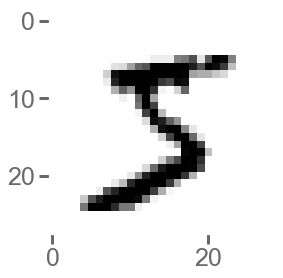

In [24]:
# sample

plt.imshow(XData[0].reshape(28,28), cmap = plt.cm.gray_r)


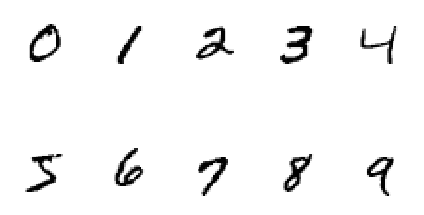

In [25]:
# Visualize samples digits

fig, ax = plt.subplots(nrows = 2, ncols = 5, sharex = True, sharey = True)

ax = ax.flatten()
for i in range(10):
    img = XData[yData == i][0].reshape(28,28)
    ax[i].imshow(img, cmap = 'Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


<a id = 'BernoulliRBM'></a>

## BernoulliRBM

The only scikit-learn implemented RBM is the BernoulliRBM module. It allows for values between zero and one because the node values represent a probability that the node is activated or not, which allows for quicker learning of feature sets. To preprocess the data, we need to:

- Scale the values of pixels to values between zero and one
- Change the pixel values in place to be true if the value is over 0.5, and false otherwise.

In [26]:
# Scale to 0 and 1

XData = XData / 255.
XData = (XData > 0.5).astype(float)
np.min(XData), np.max(XData)


(0.0, 1.0)

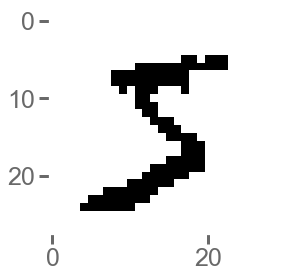

In [27]:
# sample

plt.imshow(XData[0].reshape(28,28), cmap = plt.cm.gray_r)

> Note that this image is less fuzzy than the output above.

<a id = ''></a>

## Experiment - Extracting PCA components from MNIST

<a id = ''></a>

## a

<a id = ''></a>

## a

<a id = ''></a>

## a

<a id = ''></a>

## a